# Session 3 | Demo 3.1 - Fine-tuning vs. Prompting 

by Elvis Saravia

<a href="https://colab.research.google.com/github/dair-ai/pe-for-llms/blob/main/notebooks/session-3/demo-3.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The demo shows a comparison on fine-tuned results vs. few-shot learning and zero-shot learning results.

## Using Fine-tuned models

In [2]:
%%capture
# update or install the necessary libraries
!pip install --upgrade openai
!pip install --upgrade langchain
!pip install --upgrade python-dotenv

# load libraries
import openai
import os
import IPython
from langchain.llms import OpenAI
from dotenv import load_dotenv
import json

# load the environment variables
load_dotenv()

# set the OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")


In [25]:
def set_open_params(
    model="text-davinci-003",
    temperature=0.7,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=""
):
    """ set openai parameters"""

    openai_params = {}    

    openai_params['model'] = model
    openai_params['temperature'] = temperature
    openai_params['max_tokens'] = max_tokens
    openai_params['top_p'] = top_p
    openai_params['frequency_penalty'] = frequency_penalty
    openai_params['presence_penalty'] = presence_penalty
    openai_params['stop'] = stop
    return openai_params

def get_completion(params, prompt):
    """ GET completion from openai api"""

    response = openai.Completion.create(
        engine = params['model'],
        prompt = prompt,
        temperature = params['temperature'],
        max_tokens = params['max_tokens'],
        top_p = params['top_p'],
        frequency_penalty = params['frequency_penalty'],
        presence_penalty = params['presence_penalty'],
        stop = params['stop']
    )
    return response

In [28]:
# basic example
params = set_open_params(model="curie:ft-dair:emotionft-2023-04-19-23-24-21", stop=["\n"])

prompt = "I am summer happy!\n\n###\n\n"

response = get_completion(params, prompt)

In [29]:
response

<OpenAIObject text_completion id=cmpl-7BtRvf88coDcK1cU49ogtdip4QJp6 at 0x7f7830ab6a90> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": " joy"
    }
  ],
  "created": 1683069111,
  "id": "cmpl-7BtRvf88coDcK1cU49ogtdip4QJp6",
  "model": "curie:ft-dair:emotionft-2023-04-19-23-24-21",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 9,
    "total_tokens": 10
  }
}

In [40]:
# basic example
params = set_open_params(model="text-davinci-003")

prompt = """
Your task is to classify a piece of text into either of the following labels: "anger", "fear", "joy", "love", "sadness", and "surprise".

Just output the label as a lowercase string.

Text: {text_input}
Output:
"""
response = get_completion(params, prompt.format(text_input="I am summer happy!"))

In [41]:
response

<OpenAIObject text_completion id=cmpl-7BtT5XFcaKOWZiC9HSJqLKjqHVnlv at 0x7f77f06ca040> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "joy"
    }
  ],
  "created": 1683069183,
  "id": "cmpl-7BtT5XFcaKOWZiC9HSJqLKjqHVnlv",
  "model": "text-davinci-003",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 65,
    "total_tokens": 66
  }
}

In [43]:
# import jsonl file and convert to Pandas dataframe   
import pandas as pd

df = pd.read_json("../data/merged_training_sample_100_prepared_valid.jsonl", lines=True)


In [44]:
df

,prompt,completion
0,i feel it has only been agitated by the presen...,fear\n
1,i thought as i can often feel the rather unple...,sadness\n
2,i can t hear her with all the other kids and m...,fear\n
3,i am sure i will feel this longing again when ...,love\n
4,i had been having sexual feelings and romantic...,love\n
...,...,...
115,i feel bashful discussing it i m a closet game...,fear\n
116,i was feeling agitated and giddy all at the sa...,fear\n
117,i feel restless though and know if i close my ...,fear\n
118,i report my feelings on the ex a movie about w...,fear\n


In [47]:
df.prompt.tolist()[0:5]

['i feel it has only been agitated by the presence of the smoking\n\n###\n\n',
 'i thought as i can often feel the rather unpleasant sensation of the babys head trying to stick out of my stomach up near my ribs\n\n###\n\n',
 'i can t hear her with all the other kids and mums and nannies around me no dads of course but i m so used to being the only dad in a sea of mums and nannies that it doesn t even feel weird any more\n\n###\n\n',
 'i am sure i will feel this longing again when i go visit my dear friend in the hospital and hold her new little boy in my arms but i will go home and hold my little girl and remember god has chosen this path for me for a reason and maybe one day i will be able to put this longing behind me\n\n###\n\n',
 'i had been having sexual feelings and romantic longings for years and unlike my straight peers i had kept it all bottled up\n\n###\n\n']

### Predictions from our fine-tuned model

In [56]:
params = set_open_params(model="curie:ft-dair:emotionft-2023-04-19-23-24-21", stop=["\n"])

prompt = "I am summer happy!\n\n###\n\n"

response = get_completion(params, df.prompt.tolist()[0:5])

In [61]:
for c in response.choices:
    print(c.text)

 fear
 anger
 surprise
 love
 love


In [53]:
# batch the prompts from df.prompt.tolist() into batches of 10
prompt_batches = [df.prompt.tolist()[i:i + 10] for i in range(0, len(df.prompt.tolist()), 10)]

In [66]:
params = set_open_params(model="curie:ft-dair:emotionft-2023-04-19-23-24-21", stop=["\n"])

finetuned_responses = []

for batch in prompt_batches:
    response = get_completion(params, batch)
    finetuned_responses.append([c.text.strip(" ") for c in response.choices])

In [70]:
df.completion[0:3], prompt_batches[0][0:3], finetuned_responses[0][0:3]

(0        fear\n
 1     sadness\n
 2        fear\n
 Name: completion, dtype: object,
 ['i feel it has only been agitated by the presence of the smoking\n\n###\n\n',
  'i thought as i can often feel the rather unpleasant sensation of the babys head trying to stick out of my stomach up near my ribs\n\n###\n\n',
  'i can t hear her with all the other kids and mums and nannies around me no dads of course but i m so used to being the only dad in a sea of mums and nannies that it doesn t even feel weird any more\n\n###\n\n'],
 ['fear', 'anger', 'surprise'])

### Predictions from GPT-3 Model

This prompt can be improved as it sometimes outputs other emotions like relief. the way i deal with this is be mapping it after I get the responses.

In [157]:
# zero-shot prompt
zeroshot_prompt = """
Your task is to classify a piece of text, delimited by triple backticks, into the following emotion labels: ["anger", "fear", "joy", "love", "sadness", "surprise"].

Just output the label as a lowercase string.

Text: ```{text_input}```
Output emotion label:
"""

In [158]:
# python double for loop comprehension list
promptified_prompts_batches = [[zeroshot_prompt.format(text_input=prompt) for prompt in batch] for batch in prompt_batches]

In [159]:
# ~15 seconds

params = set_open_params(model="text-davinci-003", temperature=0)

gpt3_responses = []

for batch in promptified_prompts_batches:
    response = get_completion(params, batch)
    gpt3_responses.append([c.text.strip("\n") for c in response.choices])

In [172]:
# flatten the list of lists
gpt3_responses_flat = [item for sublist in gpt3_responses for item in sublist]
finetuned_responses_flat = [item for sublist in finetuned_responses for item in sublist]

df["gpt3-completion"] = gpt3_responses_flat
df["finetuned-completion"] = finetuned_responses_flat

# fix the completion labels

df["completion"] = df["completion"].apply(lambda x: x.strip("\n").strip(" "))

In [173]:
# map "relief" to "sadness" for the gpt3-completion
df["gpt3-completion"] = df["gpt3-completion"].apply(lambda x: "sadness" if x == "relief" else x)

In [174]:
df["gpt3-completion"].unique()

array(['anger', 'sadness', 'love', 'joy', 'fear', 'surprise'],
      dtype=object)

In [175]:
df["finetuned-completion"].unique()

array(['fear', 'anger', 'surprise', 'love', 'joy', 'sadness'],
      dtype=object)

In [183]:
df.completion.value_counts()

fear        24
sadness     23
anger       22
surprise    21
love        15
joy         15
Name: completion, dtype: int64

In [187]:
# map completion labels to integers
completion_map = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

df["completion"] = df["completion"].map(completion_map)
df["gpt3-completion"] = df["gpt3-completion"].map(completion_map)
df["finetuned-completion"] = df["finetuned-completion"].map(completion_map)

In [188]:
# mapper back to string labels
completion_map_string = {
    0: "anger",
    1: "fear",
    2: "joy",
    3: "love",
    4: "sadness",
    5: "surprise"
}

([<matplotlib.axis.YTick at 0x7f7801b22b50>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'joy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

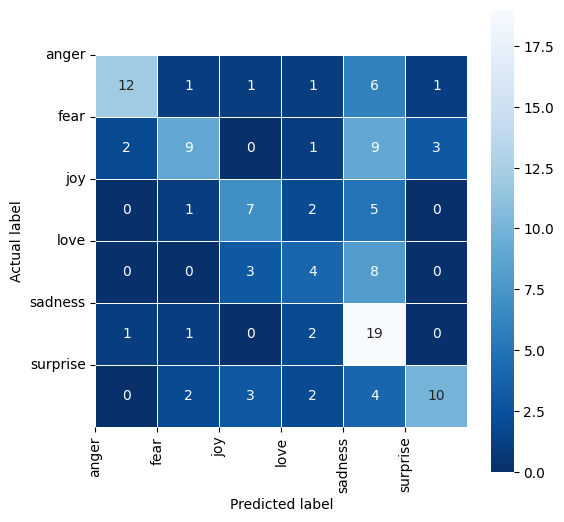

In [189]:
# plot confustion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(df["completion"], df["gpt3-completion"])

# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")


([<matplotlib.axis.YTick at 0x7f781136f940>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'joy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

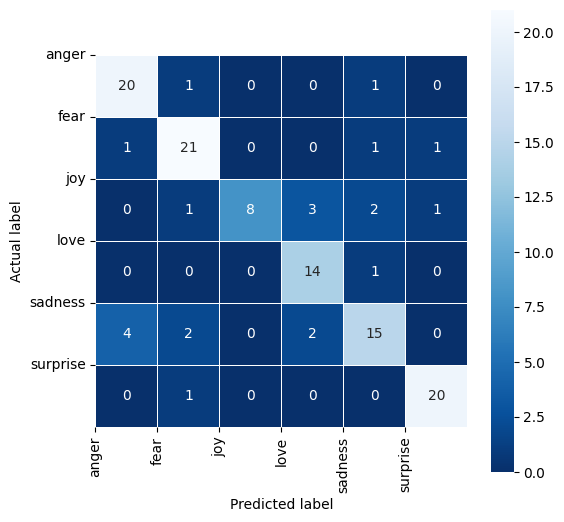

In [190]:
# plot confustion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(df["completion"], df["finetuned-completion"])

# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with emotion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")